In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.version
sys.version_info

'3.7.0 (default, Jun 28 2018, 13:15:42) \n[GCC 7.2.0]'

sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)

In [3]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp

from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from PIL import Image

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [4]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

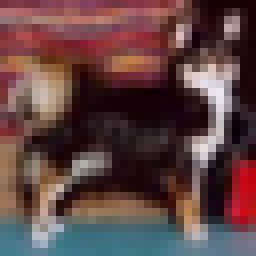

In [5]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

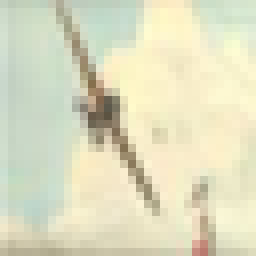

In [6]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [7]:
list((TRAIN_PATH).iterdir())
list((TRAIN_PATH).iterdir())[0].is_dir()

[PosixPath('data/cifar10_dog_air/train/dog'),
 PosixPath('data/cifar10_dog_air/train/airplane')]

True

In [8]:
#export
def find_classes(folder):
    # return class list
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    # get all image file name from class
    return [o for o in c.iterdir()
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1) # width x height x channels
    arr = arr.permute(2,0,1) # layers x height x width
    return arr.float().div_(255)

In [9]:
#export
class FilesDataset(Dataset):
    def __init__(self, folder, classes=None):
        # var: X:filenames,y:class (number), class (name)
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [10]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [11]:
train_ds.classes

['airplane', 'dog']

In [12]:
x = PIL.Image.open(train_ds.fns[0]).convert('RGB')

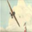

PIL.Image.Image

(32, 32)

convert to bytes -> tensor


3072

tensor([[[196, 209, 192],
         [189, 202, 184],
         [193, 207, 186],
         ...,
         [213, 228, 207],
         [213, 228, 205],
         [215, 230, 205]],

        [[205, 218, 201],
         [199, 212, 194],
         [202, 216, 194],
         ...,
         [217, 234, 211],
         [215, 233, 210],
         [217, 233, 210]],

        [[207, 220, 203],
         [200, 213, 195],
         [204, 217, 196],
         ...,
         [212, 229, 203],
         [211, 228, 206],
         [212, 227, 206]],

        ...,

        [[229, 222, 193],
         [219, 211, 182],
         [220, 213, 185],
         ...,
         [236, 237, 205],
         [235, 236, 203],
         [236, 235, 200]],

        [[210, 203, 175],
         [197, 190, 162],
         [206, 199, 170],
         ...,
         [228, 228, 197],
         [231, 231, 199],
         [234, 233, 199]],

        [[191, 184, 157],
         [180, 173, 146],
         [183, 176, 149],
         ...,
         [208, 207, 177],
        

In [13]:
x
type(x)
x.size

print('convert to bytes -> tensor')

temp=torch.ByteStorage(x.tobytes())
temp.size()
torch.ByteTensor(temp).view(x.size[1],x.size[0],-1)

In [14]:
train_ds.fns[:5]
train_ds.y[:5]

[PosixPath('data/cifar10_dog_air/train/airplane/5665_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/42446_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/43184_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/7930_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/30257_airplane.png')]

[0, 0, 0, 0, 0]

In [15]:
train_ds[0][0].size()

torch.Size([3, 32, 32])

In [16]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [17]:
#export
def image2np(image): return image.cpu().permute(1,2,0).numpy() # h x w x c

airplane


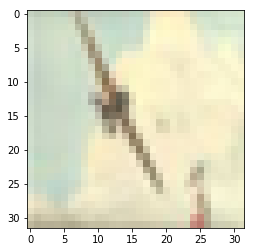

In [18]:
x,y = train_ds[0]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [19]:
bs=64

In [48]:
??DataBunch

In [20]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [21]:
#export
def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    # show row x row image matrix with class label
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows, classes, figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

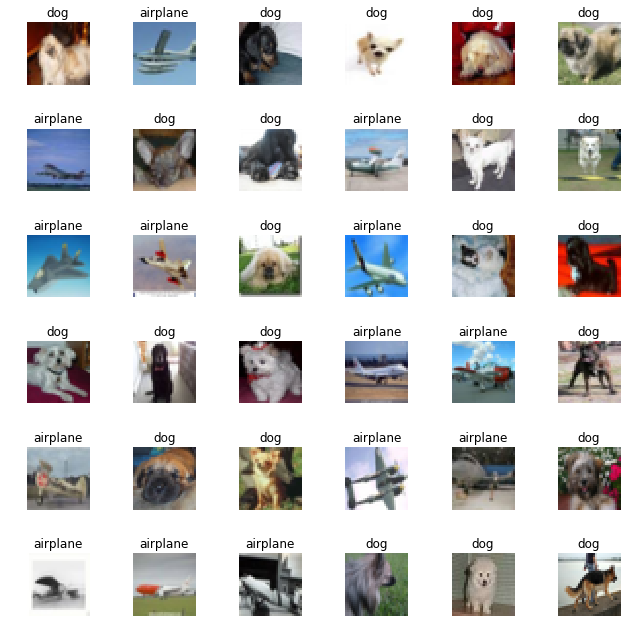

In [22]:
show_image_batch(data.train_dl, train_ds.classes, rows=6)

# Data augmentation

Now we are going augment our data to increase our training set. We will start by changing the brightness and contrast of our images.

Brightness is computed by taking the logit of the change and adding it to the logit of the images pixels. Finally we take the sigmoid of the result.

Contrast is computed by simply multiplying pixel values by the scale.

## Lighting

In [ ]:
#export
def logit(x): return (x/(1-x)).log()
def logit_(x): return (x.div_(1-x)).log_()

def brightness(x, change): return x.add_(scipy.special.logit(change))
def contrast(x, scale): return x.mul_(scale)

def apply_lighting(func): return lambda x: func(logit_(x)).sigmoid()

In [ ]:
def apply_contrast(scale): return apply_lighting(partial(contrast, scale=scale))

In [ ]:
x = lambda: train_ds[1][0]

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])

In [ ]:
def apply_brightness(change):
    return apply_lighting(partial(brightness, change=change))

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.5)(x()), axes[1])
show_image(apply_brightness(0.8)(x()), axes[2])
show_image(apply_brightness(0.2)(x()), axes[3])

In [ ]:
#export
def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

def compose(funcs):
    def _inner(x, *args, **kwargs):
        for f in funcs: x = f(x, *args, **kwargs)
        return x
    return _inner

In [ ]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    return apply_lighting(compose([
        partial(contrast, scale=scale_contrast),
        partial(brightness, change=change_brightness)
    ]))

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0])
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[1])
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[2])
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[3])

## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the transforms pipeline. We will achieve this by making our parameters stochastic with a specific distribution: uniform for brightness and log_uniform for contrast. **TODO WHY**

In [ ]:
#export
def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

def log_uniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p, size=None): return uniform(0,1,size)<p

TfmType = IntEnum('TfmType', 'Start Affine Coord Pixel Lighting')

def brightness(x, change: uniform) -> TfmType.Lighting:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale: log_uniform) -> TfmType.Lighting:
    return x.mul_(scale)

In [ ]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

In [ ]:
#export
import inspect

def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def resolve_args(func, **kwargs):
    kwargs.pop('p', None)
    def_args = get_default_args(func)
    for k,v in func.__annotations__.items():
        if k == 'return': continue
        if not k in kwargs and k in def_args:
            kwargs[k] = def_args[k]
        else:
            arg = listify(kwargs.get(k, 1))
            kwargs[k] = v(*arg)
    return kwargs

def noop(x=None, *args, **kwargs): return x

class Transform():
    def __init__(self, func, **kwargs):
        self.func,self.kw = func,kwargs
        self.tfm_type = self.func.__annotations__['return']
        
    def __repr__(self):
        return f'{self.func.__name__}_tfm->{self.tfm_type.name}; {self.kw}'
    
    def __call__(self):
        if 'p' in self.kw and not rand_bool(self.kw['p']): return noop
        kwargs = resolve_args(self.func, **self.kw)
        return partial(self.func, **kwargs)

In [ ]:
resolve_args(brightness, change=(0.25,0.75),)

In [ ]:
contrast_tfm = partial(Transform, contrast)
tfm = contrast_tfm(scale=(0.3,3))
tfm

In [ ]:
# all the same
tfm = tfm()

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm)(x()), ax)

In [ ]:
tfm = contrast_tfm(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm())(x()), ax)

## Decorator and composition

**Continue from here**

In [ ]:
#export
def reg_partial(cl, func):
    setattr(sys.modules[func.__module__], f'{func.__name__}_tfm', partial(cl,func))
    return func

def reg_transform(func): return reg_partial(Transform, func)

def resolve_tfms(tfms): return [f() for f in listify(tfms)]

@reg_transform
def brightness(x, change: uniform) -> TfmType.Lighting:  return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale: log_uniform) -> TfmType.Lighting: return x.mul_(scale)

In [ ]:
def apply_tfms(tfms):
    func = apply_lighting(compose(resolve_tfms(tfms)))
    return lambda x: func(x.clone())

In [ ]:
x = train_ds[1][0]

In [ ]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=0.5),
        brightness_tfm(change=(0.35,0.65), p=0.5)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x), axes[0][i])
    show_image(tfm(x), axes[1][i])

# Affine

## Deterministic affine

In [ ]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [ ]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    if padding_mode=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding_mode='zeros'
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(x, matrix, size=None):
    if size is None: size = x.size()
    elif isinstance(size, int): size=(x.size(0), size, size)
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

In [ ]:
def rotate(degrees):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [ ]:
m = rotate(30)
m = x.new_tensor(m)
c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [ ]:
#export
def apply_affine(m=None, func=None):
    if m is None: m=torch.eye(3)
    def _inner(img, size=None, **kwargs):
        c = affine_grid(img,  img.new_tensor(m), size=size)
        if func is not None: c = func(c)
        return grid_sample(img, c, **kwargs)
    return _inner

In [ ]:
def zoom(scale: uniform, row_pct = 0.5, col_pct = 0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [ ]:
show_image(apply_affine(zoom(0.6))(x))

In [ ]:
show_image(apply_affine(zoom(0.6))(x, padding_mode='zeros'))

In [ ]:
show_image(apply_affine(zoom(2, 0.2, 0.2))(x))

In [ ]:
#export
def affines_mat(matrices=None):
    if matrices is None: matrices=[]
    matrices = [FloatTensor(m) for m in matrices if m is not None]
    return reduce(torch.matmul, matrices, torch.eye(3))

In [ ]:
img2 = apply_affine(rotate(30))(x)
img2 = apply_affine(zoom(1.6))(img2)
show_image(img2)

In [ ]:
c = affines_mat([zoom(1.6), rotate(30)])
show_image(apply_affine(c)(x))

In [ ]:
show_image(x)

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48))

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=24), hide_axis=False)

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48, mode='nearest'))

In [ ]:
c = affines_mat([zoom(1.6)])
show_image(apply_affine(c)(x))

In [ ]:
c = affines_mat()
show_image(apply_affine(c)(x))

## Random affine

In [ ]:
#export
class AffineTransform(Transform):
    def __call__(self): return super().__call__()()

def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

def reg_affine(func): return reg_partial(AffineTransform, func)

def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.tfm_type)
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    affine_func = apply_affine(affines_mat(affine_tfms), func=compose(coord_tfms))
    start_func = compose(start_tfms)
    pixel_func = compose(pixel_tfms)
    return lambda x, **kwargs: pixel_func(lighting_func(affine_func(start_func(x.clone()), **kwargs)))

In [ ]:
#export
@reg_affine
def rotate(degrees: uniform) -> TfmType.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

@reg_affine
def zoom(scale: uniform = 1.0, row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Affine:
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [ ]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x, size=64, padding_mode='zeros'), ax)

# Coord and pixel

## Jitter / flip

In [ ]:
#export
@reg_transform
def jitter(x, magnitude: uniform) -> TfmType.Coord:
    return x.add_((torch.rand_like(x)-0.5)*magnitude*2)

In [ ]:
tfm = jitter_tfm(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

In [ ]:
#export
@reg_transform
def flip_lr(x) -> TfmType.Pixel: return x.flip(2)

In [ ]:
tfm = flip_lr_tfm(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

## Combine

In [ ]:
tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-45,45.), p=0.5),
        zoom_tfm(scale=(0.6,1.6), p=0.8),
        contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.3,0.7))
]

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x, padding_mode='zeros', size=48), axes[0][i])
    show_image(tfm(x, mode='nearest'), axes[1][i])

# Fin